# Shell APD Learning eXchange DnA Notebook
## Predicting power usage in the eastern United States

## PJM Hourly Energy Consumption Data

PJM is a regional transmission organization in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

We will be using hourly power consumption data from PJM's East grid. This data set ranges from 2002-2018. The data came from PJM's website and are given in megawatts (MW).

# To do
- make heading tags - Madli
- clustering picture - Eduardo
- clustering example - Rob

## Overview:

1. [Import packages](#setup)
2. [Get the data](#data)
3. [Explore the data](#explore)
4. [Split training and test sets](#traintest)
5. [Select and train a model for regression](#model)
    - [Linear regression](#linear)
    - [Gradient-boosted trees](#xgbreg)
    
    
6. [Engineer new features](#featureengineer)
7. [Clean the dataset](#cleaning)
8. [Test your model with new features](#modelnew)

9. [Select and train a model for classification](#classification)
    - [Gradient-boosted trees](#xgbclass)



    
REGRESSION | CLASSIFICATION
- | - 
![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/LR.png?raw=true) | ![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/CLASS1.png?raw=true)


## 1. Import some python libararies and define functions we'll need <a class="anchor" id="setup"></a>

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.style.use('fivethirtyeight')
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import math
from datetime import datetime

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)

## 2. Download the data to our notebook <a class="anchor" id="data"></a>


In [38]:
url = 'https://github.com/robmoratore/ShellDnA/raw/master/data/PJM_Load.csv'
df_full = pd.read_csv(url, sep = ',', date_parser=["date"])
pjme = df_full[['date', 'load', 'dayofyear']]

Let's look at the first few rows of the dataset

In [39]:
pjme.head()

,date,load,dayofyear
0,2002-01-01 01:00:00,30393,1
1,2002-01-01 02:00:00,29265,1
2,2002-01-01 03:00:00,28357,1
3,2002-01-01 04:00:00,27899,1
4,2002-01-01 05:00:00,28057,1


## 3. Exploring the data <a class="anchor" id="setup"></a>
Plotting energy usage over time

[Text(0,0.5,'Energy'), Text(0.5,0,'Time')]

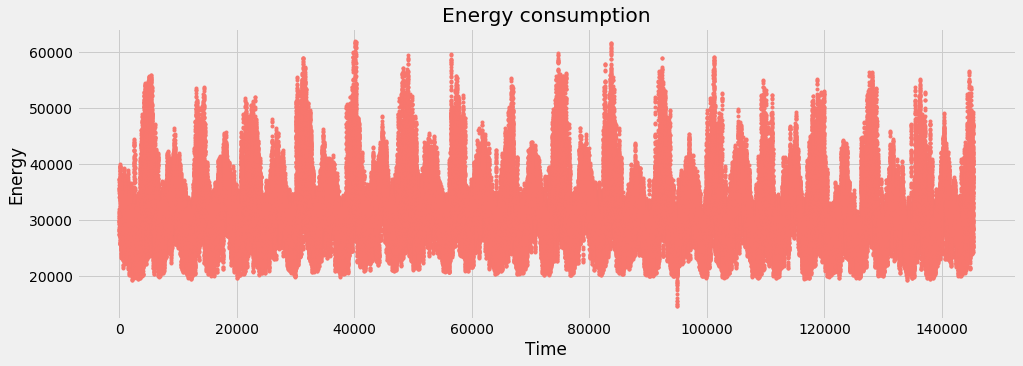

In [40]:
_ = pjme["load"].plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy consumption')
_.set(xlabel="Time", ylabel="Energy")

## 4. Splitting the training and test data <a class="anchor" id="traintest"></a>
### We do that to ensure our model is able to generalize. That means, perform well on unseen data. If we train and test using the same data, the model will memorize that specific output and not learn it.

We will use the data from 2015 on as our test set.

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/train_test.png?raw=true)

In [41]:
split_date = '2015-01-01'
pjme_train = pjme.loc[pjme['date'] <= split_date].copy()
pjme_test = pjme.loc[pjme['date'] > split_date].copy()

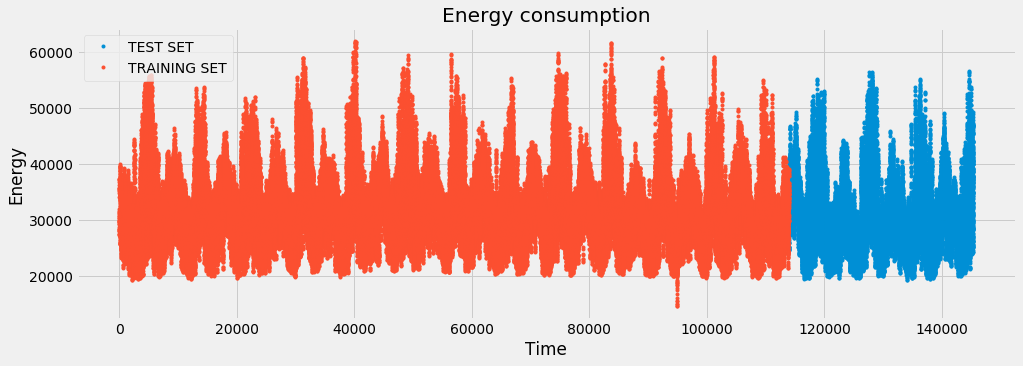

In [42]:
ax = pd.DataFrame(pjme_test["load"]) \
    .rename(columns={'load': 'TEST SET'}) \
    .join(pd.DataFrame(pjme_train["load"]).rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Energy consumption', style='.')

_ = ax.set(xlabel="Time", ylabel="Energy")

# 5. Select and train a model for regression <a class="anchor" id="model"></a>
## Can we predict how much power will be used at a given time?


## 5.1 Start with a simple model - Linear Regression <a class="anchor" id="linear"></a>

## $$ \hat{y}(w,x) = w_0 + w_1 x_1 + w_2 x_2 + ... + w_p x_p $$

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/bias.png?raw=true" />

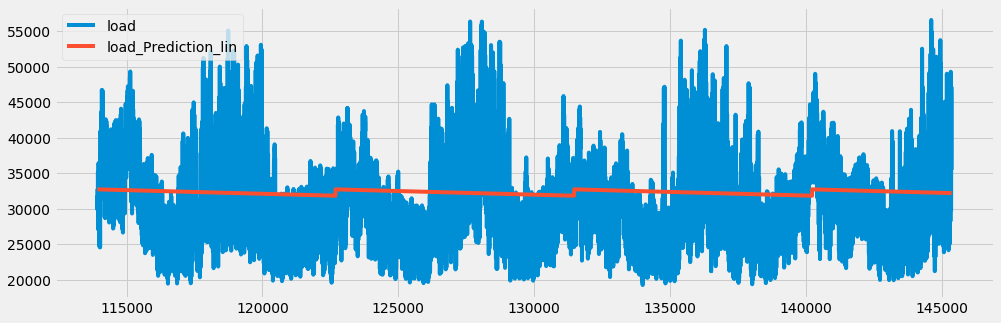

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(pjme_train["dayofyear"].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_lin'] = lin_reg.predict(pjme_test["dayofyear"].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_lin']].plot(figsize=(15, 5))

### Check how well our model performs

In [44]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin'])
print ("The Mean Squared Error (MSE) is ", mse)
print ("The Root Mean Squared Error (RMSE) is ", np.sqrt(mse))
print ("The Mean Absolute Error (MAE) is ", mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']))
print ("The Mean Absolute Percentage Error is ", mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']))
print ("The R^2 (coefficient of determination) regression score is ", r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_lin']))

The Mean Squared Error (MSE) is  42419040.4234
The Root Mean Squared Error (RMSE) is  6512.99012922
The Mean Absolute Error (MAE) is  5242.21845183
The Mean Absolute Percentage Error is  17.5961839058
The R^2 (coefficient of determination) regression score is  -0.0197213254982


## 5.2 Get fancy with some Machine Learning - XGBoost Model <a class="anchor" id="linear"></a>

This is one of the cleverest ways of combining multiple decision trees. Here, instead of having one single tree responsible for all the decisions, you use many trees on sequence. That means, the next tree does not try to predict the final result but the error of the previous tree. When you add all trees together, the results are generally very good

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb.png?raw=true)

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb2.png?raw=true)

Can you think of other ways of using multiple decision trees to make predictions?

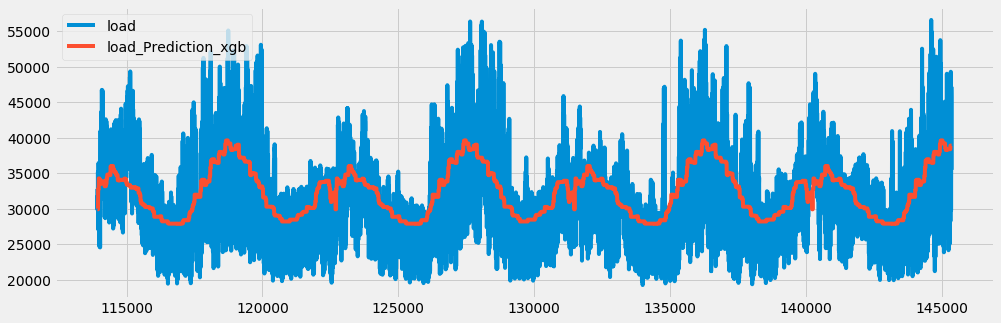

In [45]:
include_variables = "dayofyear"
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(pjme_train[include_variables].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_xgb'] = reg.predict(pjme_test[include_variables].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))

# Replace x-axis with the date

### Check how well our model performs

In [46]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", mse)
print ("The Root Mean Squared Error (RMSE) is ", np.sqrt(mse))
print ("The Mean Absolute Error (MAE) is ", mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']))
print ("The Mean Absolute Percentage Error is ", mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']))
print ("The R^2 (coefficient of determination) regression score is ", r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_xgb']))

The Mean Squared Error (MSE) is  31418659.8146
The Root Mean Squared Error (RMSE) is  5605.23503652
The Mean Absolute Error (MAE) is  4386.92024615
The Mean Absolute Percentage Error is  14.7755553817
The R^2 (coefficient of determination) regression score is  0.24471942053


## 6. Engineering New Features <a class="anchor" id="newfeatures"></a>

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/pipeline.png?raw=true)


#### Here, we can create features to distinguish a seashell image from the Shell's logo. For example, we can have a feature "yellow" that represents the amount of yellow pixels present in the picture (in %, for example). That feature, will help the machine learning model to distinguish between the two images. Another example is the image's symmetry (yes/no).


![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/shell.png?raw=true)


#### We created some features ahead of time for you 

In [47]:
df_full.head()

,date,load,load_1h,loadmean_6h,loadmean_12h,loadmean_24h,load_peak,year,quarter,month,weekofyear,dayofyear,dayofmonth,dayofweek,hour,daytime,weekend,holiday,businessday,season,temp,precipitation
0,2002-01-01 01:00:00,30393,NaN,NaN,NaN,NaN,30578.830254,2002,1,1,1,1,1,3,1,0,0,1,0,1,21.2,0.0
1,2002-01-01 02:00:00,29265,30393.0,NaN,NaN,NaN,29660.996187,2002,1,1,1,1,1,3,2,0,0,1,0,1,21.2,0.0
2,2002-01-01 03:00:00,28357,29265.0,NaN,NaN,NaN,31142.889741,2002,1,1,1,1,1,3,3,0,0,1,0,1,21.2,0.0
3,2002-01-01 04:00:00,27899,28357.0,NaN,NaN,NaN,28939.300806,2002,1,1,1,1,1,3,4,0,0,1,0,1,21.2,0.0
4,2002-01-01 05:00:00,28057,27899.0,NaN,NaN,NaN,29395.439657,2002,1,1,1,1,1,3,5,0,0,1,0,1,21.2,0.0


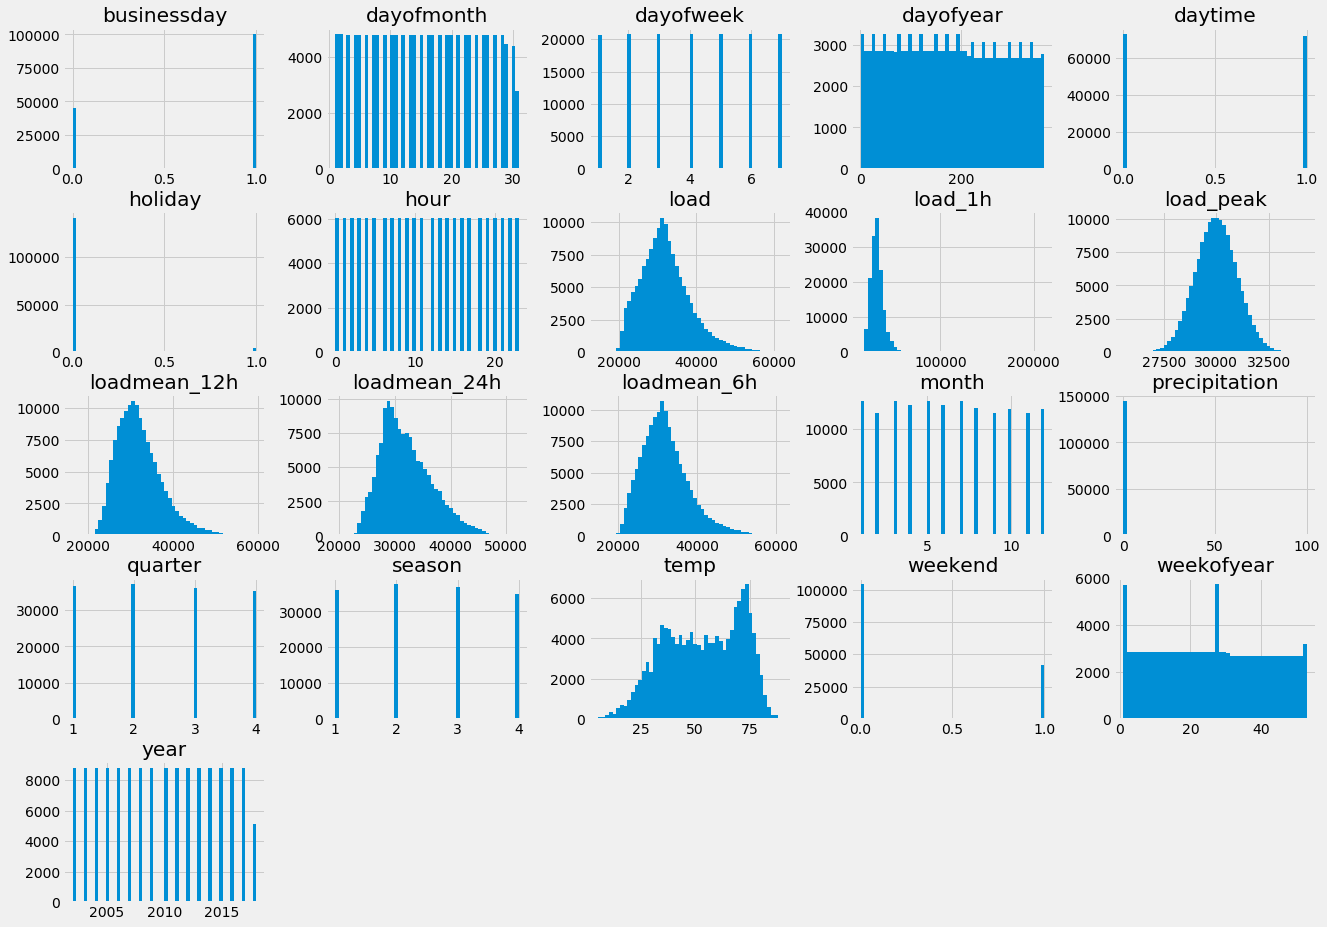

In [48]:
_ = df_full.hist(bins=50, figsize=(20,15))

## 7. Cleaning the dataset <a class="anchor" id="cleaning"></a>

Let's look closer at our data to see if there are any anomalies that need to be cleaned.

In [49]:
df_full.describe().round()

,load,load_1h,loadmean_6h,loadmean_12h,loadmean_24h,load_peak,year,quarter,month,weekofyear,dayofyear,dayofmonth,dayofweek,hour,daytime,weekend,holiday,businessday,season,temp,precipitation
count,145366.0,145361.0,145356.0,145344.0,145320.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0,145366.0
mean,32080.0,32083.0,32080.0,32080.0,32079.0,29998.0,2010.0,2.0,6.0,26.0,180.0,16.0,4.0,12.0,0.0,0.0,0.0,1.0,2.0,53.0,0.0
std,6464.0,6504.0,6081.0,5398.0,4685.0,999.0,5.0,1.0,3.0,15.0,105.0,9.0,2.0,7.0,0.0,0.0,0.0,0.0,1.0,18.0,4.0
min,14544.0,14544.0,14970.0,16279.0,19307.0,25543.0,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0
25%,27573.0,27573.0,27818.0,28166.0,28607.0,29325.0,2006.0,1.0,3.0,13.0,90.0,8.0,2.0,6.0,0.0,0.0,0.0,0.0,2.0,39.0,0.0
50%,31421.0,31421.0,31353.0,31283.0,31327.0,29996.0,2010.0,2.0,6.0,26.0,179.0,16.0,4.0,12.0,0.0,0.0,0.0,1.0,2.0,54.0,0.0
75%,35650.0,35650.0,35364.0,35088.0,34972.0,30671.0,2014.0,3.0,9.0,39.0,271.0,23.0,6.0,18.0,1.0,1.0,0.0,1.0,3.0,69.0,0.0
max,62009.0,211492.0,61410.0,59693.0,52261.0,34338.0,2018.0,4.0,12.0,53.0,366.0,31.0,7.0,23.0,1.0,1.0,1.0,1.0,4.0,90.0,100.0


If we look at the `load_1h` column, the maximum vaue is almost **7x larger** than the mean, where for the other load values the max is about **2x larger** than the mean. Let's look closer at the histogram.

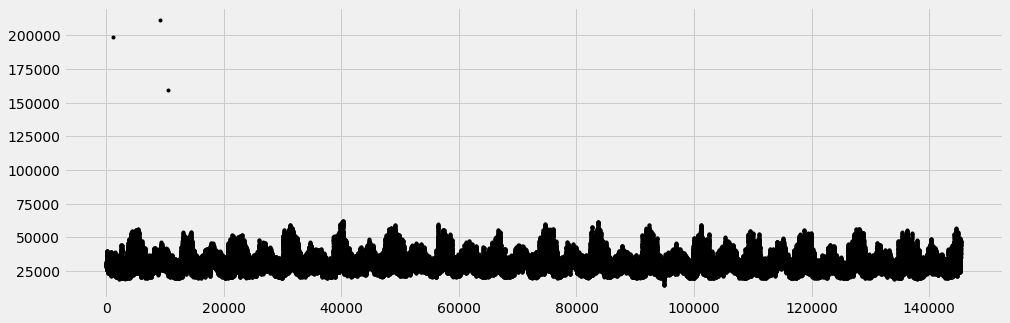

In [50]:
_ = df_full["load_1h"].plot(style='k.', figsize=(15,5))

We can see in the plot above, 3 data points that are outliers. Since they are all in our training set, we should filter them out.

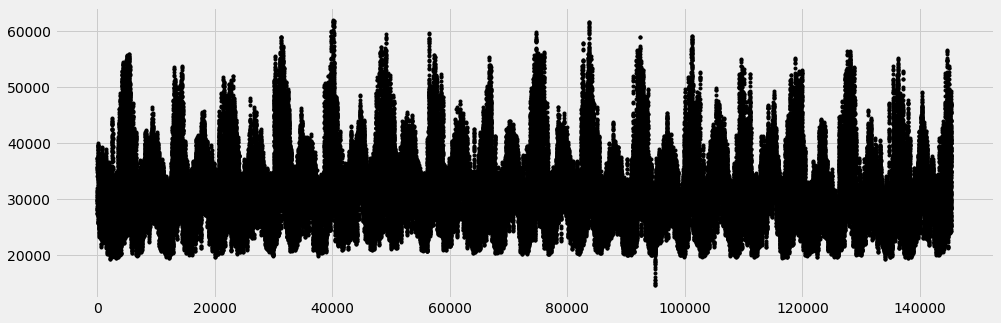

In [51]:
df_full = df_full[df_full['load_1h']<=70000]
_ = df_full["load_1h"].plot(style='k.', figsize=(15,5))

In [52]:
len(df_full.index)-df_full.count()

date              0
load              0
load_1h           0
loadmean_6h       8
loadmean_12h     20
loadmean_24h     44
load_peak         0
year              0
quarter           0
month             0
weekofyear        0
dayofyear         0
dayofmonth        0
dayofweek         0
hour              0
daytime           0
weekend           0
holiday           0
businessday       0
season            0
temp              0
precipitation     0
dtype: int64

### How to handle missing values? 

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/missingData.png?raw=true)

A simple, and yet effective, way to handling missing values is to simply delete the entire row observation. What would be one downside of this approach?

Another way is to fill the wholes with an "educated guess". Can you think of ways of doing that? (Hint: think statistics!)

In [53]:
df_full = df_full.dropna()
len(df_full.index)-df_full.count()

date             0
load             0
load_1h          0
loadmean_6h      0
loadmean_12h     0
loadmean_24h     0
load_peak        0
year             0
quarter          0
month            0
weekofyear       0
dayofyear        0
dayofmonth       0
dayofweek        0
hour             0
daytime          0
weekend          0
holiday          0
businessday      0
season           0
temp             0
precipitation    0
dtype: int64

## 8. Testing XGBoost model with new features <a class="anchor" id="modelnew"></a>

We can now re train the XGBoost model using the new features to see if performance improves.

Here is a list of available features that can be used in the model.

In [54]:
df_full.drop(columns=['date', 'load']).columns

Index(['load_1h', 'loadmean_6h', 'loadmean_12h', 'loadmean_24h', 'load_peak',
       'year', 'quarter', 'month', 'weekofyear', 'dayofyear', 'dayofmonth',
       'dayofweek', 'hour', 'daytime', 'weekend', 'holiday', 'businessday',
       'season', 'temp', 'precipitation'],
      dtype='object')

Select which features you would like to include in the model, and add them to the `include_variables` list bellow.
Then check how the model performs.

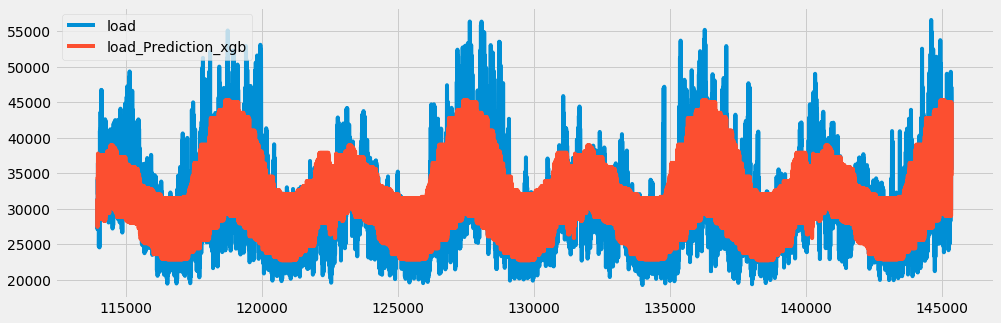

In [55]:
# SELECT A COMBINATION OF FEATURES HERE
include_variables = ['hour', 'dayofyear']  

split_date = '2015-01-01'
df_full_train = df_full.loc[df_full['date'] <= split_date].copy()
df_full_test = df_full.loc[df_full['date'] > split_date].copy()

reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(df_full_train[include_variables], df_full_train["load"].values.reshape(-1, 1))
df_full_test['load_Prediction_xgb'] = reg.predict(df_full_test[include_variables])
_ = df_full_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))

### Check how well our model performs
Which Feature give you the lowest RMSE score?

In [56]:
mse = mean_squared_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", mse)
print ("The Root Mean Squared Error (RMSE) is ", np.sqrt(mse))
print ("The Mean Absolute Error (MAE) is ", mean_absolute_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']))
print ("The Mean Absolute Percentage Error is ", mean_absolute_percentage_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']))
print ("The R^2 (coefficient of determination) regression score is ", r2_score(y_true=df_full_test['load'],y_pred=df_full_test['load_Prediction_xgb']))

The Mean Squared Error (MSE) is  16310828.0095
The Root Mean Squared Error (RMSE) is  4038.66661282
The Mean Absolute Error (MAE) is  3184.40771505
The Mean Absolute Percentage Error is  10.3701051183
The R^2 (coefficient of determination) regression score is  0.608167076664


### Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

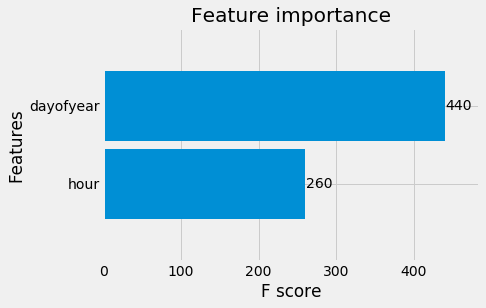

In [57]:
_ = plot_importance(reg, height=0.9)

In [71]:
df_full_test[include_variables]

,hour,dayofyear
date,,
2015-01-01 23:00:00,23,1
2015-01-02 00:00:00,0,2
2015-01-02 01:00:00,1,2
2015-01-02 02:00:00,2,2
2015-01-02 03:00:00,3,2
2015-01-02 04:00:00,4,2
2015-01-02 05:00:00,5,2
2015-01-02 06:00:00,6,2
2015-01-02 07:00:00,7,2


## 9. Looking at Worst and Best Predicted Days <a class="anchor" id="bestworst"></a>

In [58]:
df_full_test['error'] = df_full_test['load'] - df_full_test['load_Prediction_xgb']
df_full_test['abs_error'] = df_full_test['error'].apply(np.abs)
error_by_day = df_full_test.groupby(['year','month','dayofmonth']) \
    .mean()[['load','load_Prediction_xgb','error','abs_error']]

df_plot=df_full_test
df_plot.index=df_plot['date']
df_plot=df_plot[['load_Prediction_xgb','load']]

### Worst days

In [59]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

load  load_Prediction_xgb         error  \
year month dayofmonth                                                    
2015 2     20          44694.041667         33142.585938  11551.457031   
2016 9     9           43836.958333         33038.949219  10798.009766   
2015 2     16          43949.500000         33422.554688  10526.946289   
2017 7     30          28025.666667         38543.777344 -10518.112305   
2018 1     5           44197.791667         33903.050781  10294.740234   
           1           40191.041667         30223.994141   9967.047852   
2017 9     2           24201.458333         34163.972656  -9962.512695   
     8     6           27709.875000         37531.199219  -9821.325195   
2015 6     28          26893.250000         36660.957031  -9767.706055   
2016 7     3           26926.125000         36660.957031  -9734.831055   

                          abs_error  
year month dayofmonth                
2015 2     20          11551.457031  
2016 9     9           10798.009766  
2015 2     16          10526.946289  
2017 7     30          10518.112305  
2018 1     5           10294.740234  
           1            9967.047852  
2017 9     2            9962.512695  
     8     6            9821.325195  
2015 6     28           9767.706055  
2016 7     3            9734.831055

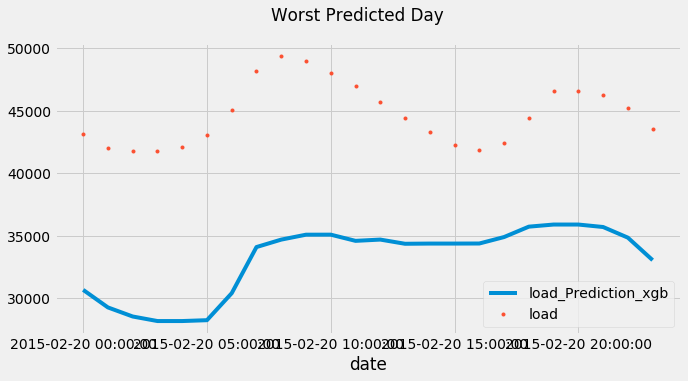

In [60]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_plot[(df_plot.index>'2015-02-20') & (df_plot.index<'2015-02-21')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Worst Predicted Day')

### Best days

In [61]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,load,load_Prediction_xgb,error,abs_error
year,month,dayofmonth,,,,
2015,1,1,31460.000000,31385.777344,74.222656,74.222656
2018,5,17,28035.208333,28365.591797,-330.383789,478.504059
2017,10,24,28657.416667,28510.458984,146.957840,516.618164
2018,5,31,31445.000000,31813.798828,-368.798828,545.901550
2015,10,28,28500.958333,28544.125000,-43.167400,576.480225
2017,5,2,28546.916667,28208.490234,338.425690,579.542725
2018,5,11,27865.333333,28211.048828,-345.715485,606.838074
2016,2,17,33311.791667,33279.621094,32.171795,610.907288
2017,2,3,34424.375000,34016.527344,407.846832,622.449036


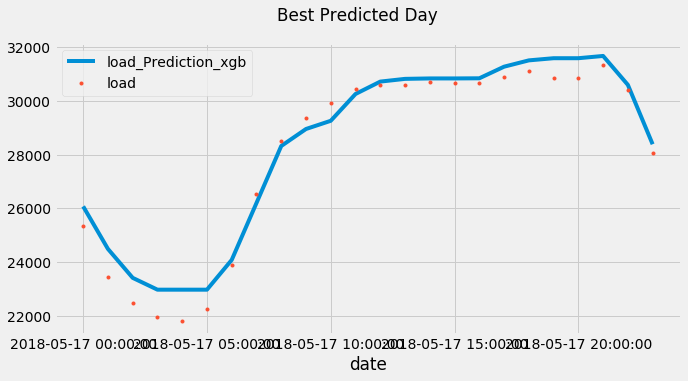

In [62]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_plot[(df_plot.index>'2018-05-17') & (df_plot.index<'2018-05-18')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Best Predicted Day')

## 8. Classification - Can we predict if a given day is a weekend or a weekday?

###  $$\hat{f}(w,x) = f\bigg(\sum_{j}w_jx_j\bigg)$$

### $$ \hat{f}(x) = \Bigr\{ { 1 \atop 0}  {if \ \textbf{w} \cdot \textbf{x} \ > \ T\atop \ otherwise} $$

In [63]:
df_day = df_full.groupby(['year','month','dayofmonth']).sum()[['load']] \
.join(df_full.groupby(['year','month','dayofmonth']).max()[['temp', 'weekend']], how='inner')
df_day.reset_index(inplace=True)
df_day['date'] = df_day['year'].astype(str) + '-' + df_day['month'].astype(str) + '-' + df_day['dayofmonth'].astype(str)
df_day['date'] = df_day['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_day.index = df_day['date']
df_day = df_day.drop(['year','month','dayofmonth', 'date'], axis=1)
df_day = df_day[df_day['load']>=500000] #remove end of year outliers which don't have 24 hours of data to sum

df_day.head()

,load,temp,weekend
date,,,
2002-01-02,822277,24.2,0
2002-01-03,828285,25.9,0
2002-01-04,809171,28.2,0
2002-01-05,729723,31.1,1
2002-01-06,727766,29.5,1


In [64]:
df_day_train = df_day.loc[df_day.index < '2015-01-01'].copy()
df_day_test = df_day.loc[df_day.index >= '2015-01-01'].copy()

X_train = df_day_train[['load', 'temp']]
y_train = df_day_train["weekend"]
X_test = df_day_test[['load', 'temp']]
y_test = df_day_test["weekend"]

In [65]:
clas = xgb.XGBClassifier(n_estimators=100)
clas.fit(X_train, y_train)
df_day_test['weekend_pred'] = clas.predict(X_test)

How to divide the classes? | Evaluation 
- | - 
![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/SVM1.png?raw=true) |  ![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/PrecRec.jpg?raw=true)

Normalized confusion matrix
[[ 0.73  0.27]
 [ 0.13  0.87]]


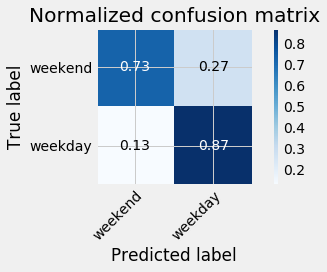

In [66]:
plot_confusion_matrix(df_day_test['weekend'], df_day_test['weekend_pred'], classes=["weekend", "weekday"], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

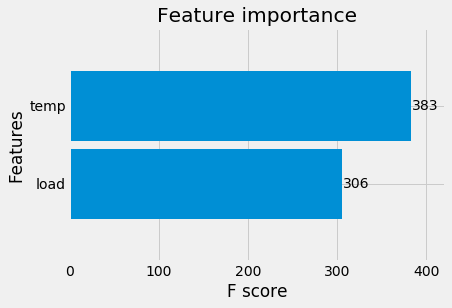

In [67]:
_ = plot_importance(clas, height=0.9)

In [68]:
# Try it out yourself
d = dict({"load":32802,"temp":28.6})
df = pd.DataFrame(d, range(len(d)-1))
clas.predict(df)

array([1])

## What are the next steps?